In [1]:
import pandas as pd
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import matplotlib.pyplot as plt
import os
import numpy as np
import librosa
import librosa.display

In [2]:
def get_trackids_from_directory(audio_dir):
    """
    Get track IDs from the mp3s in a directory.
    Parameters
    ----------
    audio_dir : str
        Path to the directory where the audio files are stored.
    Returns
    -------
        A list of track IDs.
    """
    trackids = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            trackids.extend(int(file[:-4]) for file in files)
    return trackids

In [3]:
def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    trackid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, trackid_str[:3], trackid_str + '.mp3')

In [4]:
AUDIO_DIR = 'C:/Users/Gabriele/Documents/GitHub/music-genre-recognition/data/fma_small'

In [5]:
trackids = get_trackids_from_directory(AUDIO_DIR)
print(len(trackids))

8000


## Function to create spectograms

In [6]:
def create_spectogram(track_id):
    filename = get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(filename)
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect.T

In [7]:
def plot_spect(track_id):
    spect = create_spectogram(track_id)
    print(spect.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

C:\Users\Gabriele\anaconda3\envs\genre-recognition\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(646, 128)


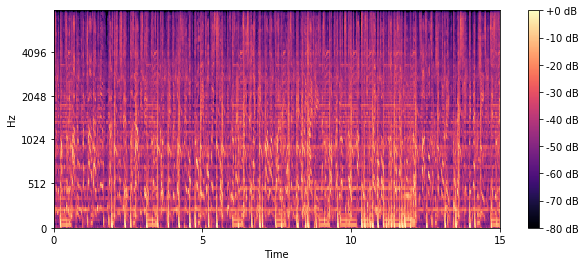

In [8]:
plot_spect(2)

## Load dataset with genre and track IDs

In [9]:
filepath = '../data/fma_metadata/tracks.csv'
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])
keep_cols = [('set', 'split'), ('set', 'subset'), ('track', 'genre_top')]

df_all = tracks[keep_cols]
df_all = df_all[df_all[('set', 'subset')] == 'small']

df_all['track_id'] = df_all.index
df_all.head()

set            track track_id
             split subset genre_top         
track_id                                    
2         training  small   Hip-Hop        2
5         training  small   Hip-Hop        5
10        training  small       Pop       10
140       training  small      Folk      140
141       training  small      Folk      141

In [10]:
df_all.shape

(8000, 4)

In [11]:
df_all[('track', 'genre_top')].unique()

array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

In [12]:
dict_genres = {'Electronic':1, 'Experimental':2, 'Folk':3, 'Hip-Hop':4, 'Instrumental':5,'International':6, 'Pop' :7, 'Rock': 8}

## Create Arrays

In [13]:
def create_array(df):
    genres = []
    X_spect = np.empty((0, 640, 128))
    count = 0
    #Code skips records in case of errors
    for index, row in df.iterrows():
        try:
            count += 1
            track_id = int(row['track_id'])
            genre = str(row[('track', 'genre_top')])
            spect = create_spectogram(track_id)

            # Normalize for small shape differences
            spect = spect[:640, :]
            X_spect = np.append(X_spect, [spect], axis=0)
            genres.append(dict_genres[genre])
            if count % 100 == 0:
                print("Currently processing: ", count)
        except:
            print("Couldn't process: ", count)
            continue
    y_arr = np.array(genres)
    return X_spect, y_arr

In [14]:
df_all[('set', 'split')].unique()

array(['training', 'validation', 'test'], dtype=object)

## Create train, validation and test subsets

In [15]:
df_train = df_all[df_all[('set', 'split')]=='training']
df_valid = df_all[df_all[('set', 'split')]=='validation']
df_test = df_all[df_all[('set', 'split')]=='test']

print(df_train.shape, df_valid.shape, df_test.shape)

(6400, 4) (800, 4) (800, 4)


In [23]:
X_test, y_test = create_array(df_test)

C:\Users\Gabriele\anaconda3\envs\genre-recognition\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800


In [24]:
print(X_test.shape, y_test.shape)

(800, 640, 128) (800,)


In [25]:
print(y_test[:23])

[8 6 6 6 6 6 6 3 3 2 2 2 2 2 2 8 8 2 2 2 2 2 2]


In [26]:
np.savez('test_arr', X_test, y_test)

In [27]:
X_valid, y_valid = create_array(df_valid)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800


In [28]:
np.savez('valid_arr', X_valid, y_valid)

##### Note: Train data split into 4 chunks to do the slow pre-processing in phases

In [17]:
def splitDataFrameIntoSmaller(df, chunkSize = 1600): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

In [18]:
listDf = splitDataFrameIntoSmaller(df_train)
df1_train = listDf[0]
df2_train = listDf[1]
df3_train = listDf[2]
df4_train = listDf[3]
print(df1_train.shape, df2_train.shape, df3_train.shape, df4_train.shape)

(1600, 4) (1600, 4) (1600, 4) (1600, 4)


In [19]:
X_train1, y_train1 = create_array(df1_train)

C:\Users\Gabriele\anaconda3\envs\genre-recognition\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600


In [20]:
np.savez('train1_arr', X_train1, y_train1)

In [21]:
print(X_train1.shape, y_train1.shape)

(1600, 640, 128) (1600,)


In [22]:
X_train2, y_train2 = create_array(df2_train)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600


In [23]:
np.savez('train2_arr', X_train2, y_train2)

In [24]:
print(X_train2.shape, y_train2.shape)

(1600, 640, 128) (1600,)


In [25]:
X_train3, y_train3 = create_array(df3_train)

Currently processing:  100
Currently processing:  200
Couldn't process:  296
Couldn't process:  297
Couldn't process:  298
Currently processing:  300
Couldn't process:  331
Currently processing:  400
Currently processing:  500
Currently processing:  600
Couldn't process:  698
Currently processing:  700
Currently processing:  800
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600


In [26]:
print(X_train3.shape, y_train3.shape)

(1595, 640, 128) (1595,)


In [27]:
np.savez('train3_arr', X_train3, y_train3)

In [28]:
X_train4, y_train4 = create_array(df4_train)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800
Couldn't process:  812
Currently processing:  900
Currently processing:  1000
Currently processing:  1100
Currently processing:  1200
Currently processing:  1300
Currently processing:  1400
Currently processing:  1500
Currently processing:  1600


In [29]:
np.savez('train4_arr', X_train4, y_train4)

In [30]:
print(X_train4.shape, y_train4.shape)

(1599, 640, 128) (1599,)
